# Locally Dense Autoencoder Neural Network based denoising

In [1]:
import os
import sys

sys.path.append(os.path.join(os.getcwd(), ".."))

import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from matplotlib.colors import LogNorm

from torch import nn, optim, no_grad

from line_cube_denoising.dataset import CubeDataset
from line_cube_denoising.networks import Autoencoder, DenseAutoencoder
from line_cube_denoising.training import ReconstructionLoss, InformedLoss, LearningParameters, learning_procedure

data_path = os.path.join(os.getcwd(), "..", "cubes")
results_path = os.path.join(os.getcwd(), "out_dense_ae")

raise NotImplementedError("This notebook is currently not stable")

In [2]:
# Creation of the dataset

line_name = "13co10"

hdu = fits.open(os.path.join(data_path, f"{line_name}.fits"))[0]
cube = hdu.data
header = hdu.header

mask_cube = fits.open(os.path.join(data_path, line_name, f"{line_name}_mask.fits"))[0].data
noise_map = fits.open(os.path.join(data_path, line_name, f"{line_name}_noise_map.fits"))[0].data

cube = cube.astype(np.float32)
mask_cube = mask_cube.astype(np.float32)
noise_map = noise_map.astype(np.float32)

In [3]:
channels_range = (80, 160)
n_inputs = channels_range[1] - channels_range[0]

dataset = CubeDataset(
    cube[slice(*channels_range)],
    mask_cube[slice(*channels_range)],
    noise_map
)

nx, ny, nz = dataset.nx, dataset.ny, dataset.nz

Dataset created: 80 features, 814092 samples


In [4]:
# Creation of the architecture

bottleneck_size = round(0.75*n_inputs)
half_description = [n_inputs, 5*n_inputs, 5*n_inputs, 5*n_inputs, bottleneck_size]
activation = nn.ELU()

model = DenseAutoencoder(
    half_description,
    activation,
)

In [5]:
# Training parameters

normalize = True
# loss = ReconstructionLoss(normalize=normalize)
loss = InformedLoss(normalize=normalize)

epochs = 50
batch_size = 1_000

lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr)

gamma = 0.95
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma)

learning_parameters = LearningParameters(
    loss,
    epochs,
    batch_size,
    optimizer,
    scheduler
)

In [6]:
# Training procedure

val_frac = 0.2
seed = None

results = learning_procedure(
    model,
    dataset,
    learning_parameters,
    val_frac=val_frac,
    seed = None,
    verbose=False,
)

# Alternatively, you can load an existing model
# Autoencoder.load(f"model_{line_name}")

x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x 

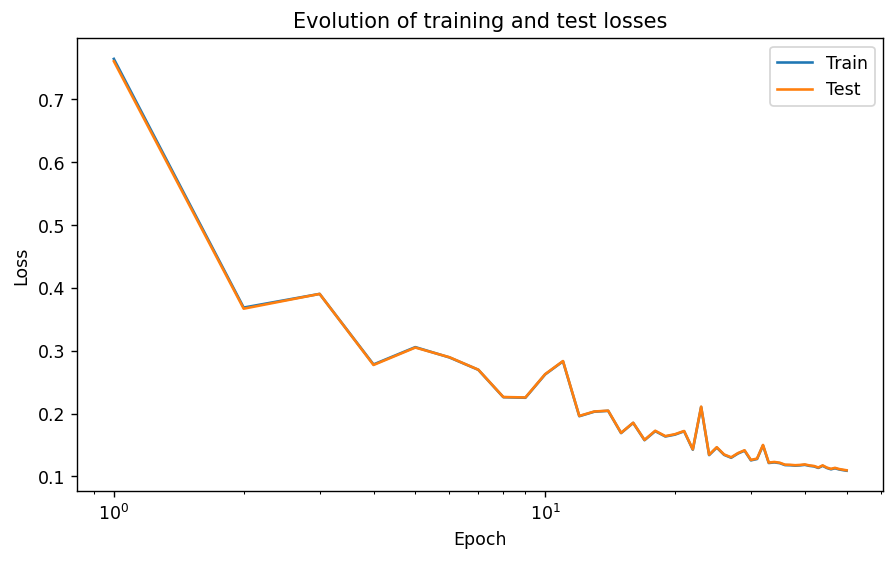

In [7]:
# Results

plt.figure(figsize=(1.3*6.4, 4.8), dpi=125)

plt.semilogx(list(range(1, epochs+1)), results["train_loss"], label="Train")
plt.semilogx(list(range(1, epochs+1)), results["val_loss"], label="Test")

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Evolution of training and test losses")

plt.legend()

plt.show()

In [8]:
x, mask, sigma = dataset[:]

model.eval()
with no_grad():
    x_hat, y_hat = model.forward(x)

# Conversion to NumPy
x = x.detach().numpy()
x_hat = x_hat.detach().numpy()
y_hat = y_hat.detach().numpy()
sigma = sigma.detach().numpy()

# Reshaping
X = x.T.reshape(nz, ny, nx)
X_hat = x_hat.T.reshape(nz, ny, nx)
Y_hat = y_hat.T.reshape(bottleneck_size, ny, nx)
Sigma = sigma.reshape(ny, nx)

# Residuals
Residuals = X - X_hat

## Mean profiles

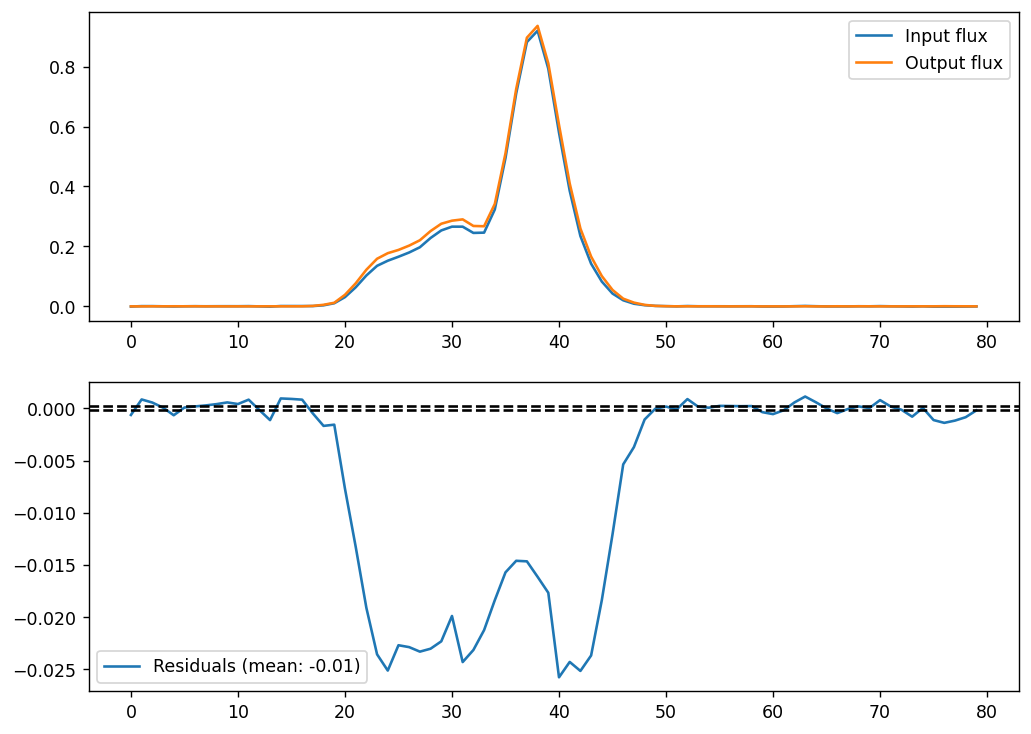

In [12]:
plt.figure(figsize=(1.5*6.4, 1.5*4.8), dpi=125)

plt.subplot(2, 1, 1)
plt.plot(np.mean(X, axis=(1, 2)), label="Input flux")
plt.plot(np.mean(X_hat, axis=(1, 2)), label="Output flux")

plt.legend()

plt.subplot(2, 1, 2)
plt.plot(np.mean(Residuals, axis=(1, 2)), label=f"Residuals (mean: {np.mean(Residuals):.2f})")

plt.legend()

plt.show()

## RMS of residuals

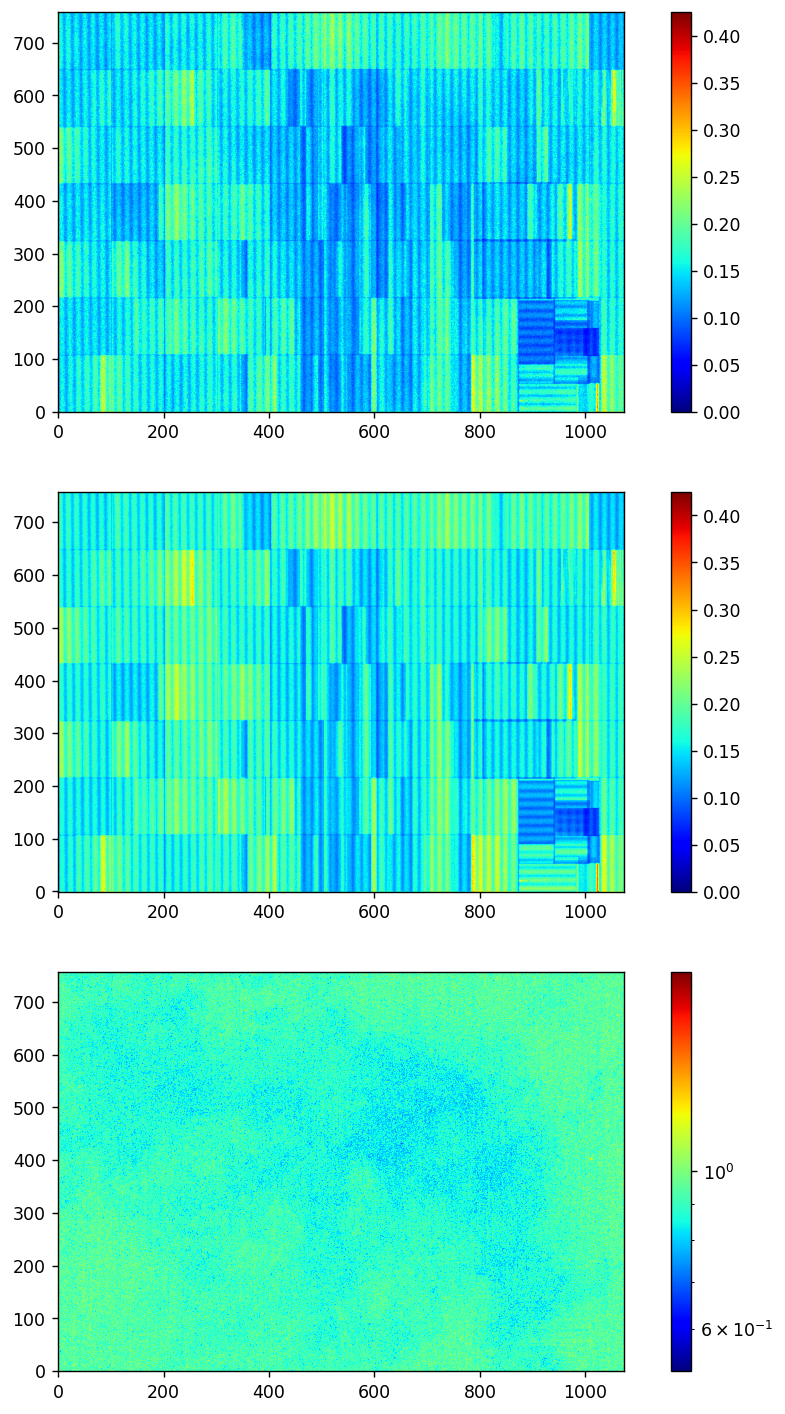

In [13]:
Residuals_rms = np.mean(Residuals**2, axis=0)**0.5
Norm_residuals_rms = Residuals_rms / Sigma

#

plt.figure(figsize=(1.5*6.4, 3*4.8), dpi=125)

plt.subplot(3, 1, 1)

vmin = 0
vmax = np.max(np.abs(Residuals_rms))

plt.imshow(Residuals_rms, origin="lower", cmap="jet", vmin=vmin, vmax=vmax)
plt.colorbar()

plt.subplot(3, 1, 2)

vmin = 0
vmax = np.max(np.abs(Residuals_rms))

plt.imshow(Sigma, origin="lower", cmap="jet", vmin=vmin, vmax=vmax)
plt.colorbar()

plt.subplot(3, 1, 3)

vmax = max(np.max(1/Norm_residuals_rms), np.max(Norm_residuals_rms))

plt.imshow(Norm_residuals_rms, origin="lower", cmap="jet", norm=LogNorm(1/vmax, vmax))
plt.colorbar()

plt.show()

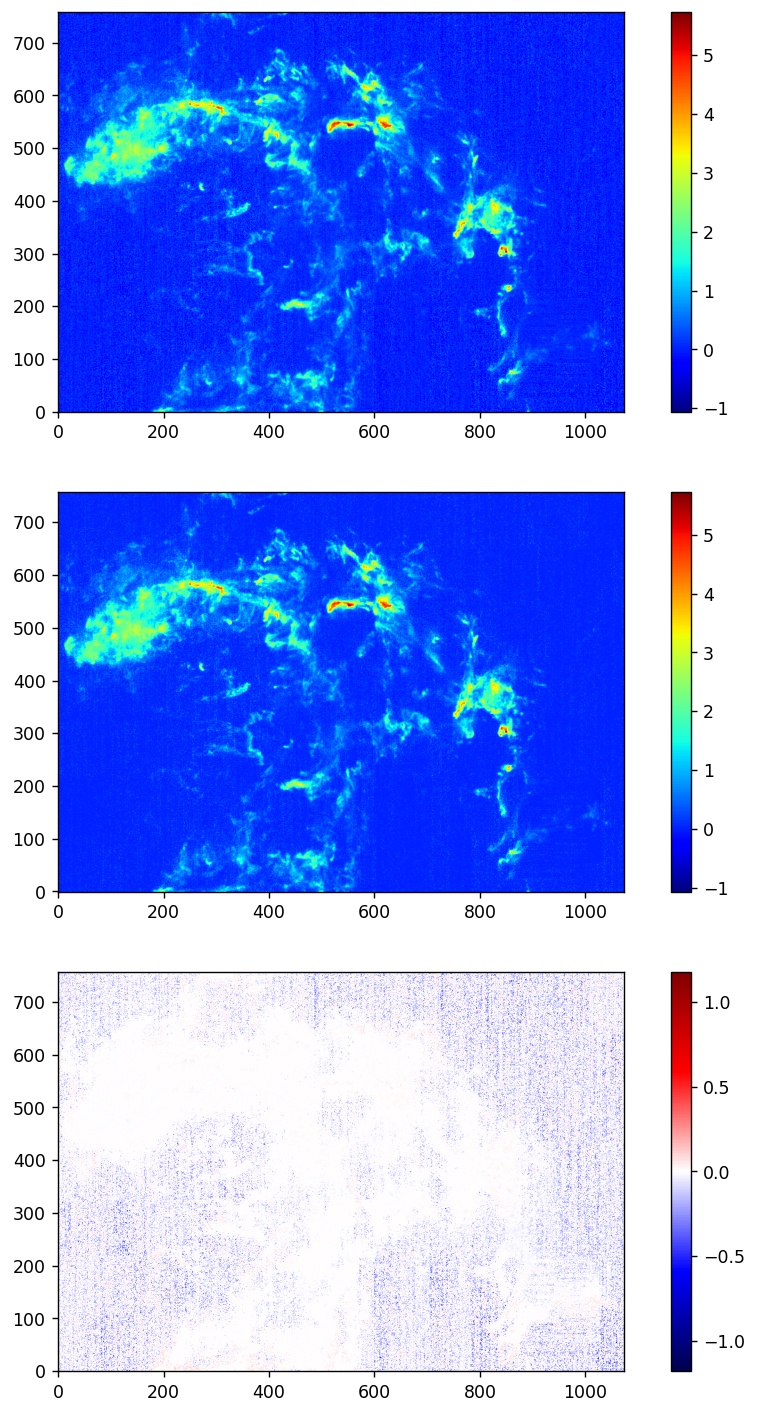

In [19]:
channel = 28

#

plt.figure(figsize=(1.5*6.4, 3*4.8), dpi=125)

vmin = min(np.min(X[channel]), np.min(X_hat[channel]))
vmax = max(np.max(X[channel]), np.max(X_hat[channel]))

plt.subplot(3, 1, 1)
plt.imshow(X[channel], origin="lower", cmap="jet", vmin=vmin, vmax=vmax)
plt.colorbar()

plt.subplot(3, 1, 2)
plt.imshow(X_hat[channel], origin="lower", cmap="jet", vmin=vmin, vmax=vmax)
plt.colorbar()

vmax = max(np.max(np.abs(Residuals[channel])), np.max(np.abs(Residuals[channel])))

plt.subplot(3, 1, 3)
plt.imshow(Residuals[channel], origin="lower", cmap="seismic", vmin=-vmax, vmax=vmax)
plt.colorbar()

plt.show()

## Model save

In [15]:
model.save(f"model_{line_name}")